# Plotting meridional heat transport

In [83]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

import matplotlib.gridspec as gridspec

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38323,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:41183,Total threads: 1
Dashboard: /proxy/38743/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:46547,


In [3]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [50]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_iaf_omip2_cycle6'#'025deg_jra55_ryf9091_gadi'
expt_OM2_1   = ''#'1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [107]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [101]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

### Meridional heat transport

The model output has a variable called `temp_yflux_adv` which is 

$$ MHT = \rho\, c_p\, v\, T\, dzt\, dxt $$ in Watts.

Sum over depth and in longitude to get global/basin average. 



OM2:

!! Can't find `temp_yflux_avg` in the OM2-1 (only 20 yr) and in the OM2-025 (nothing) RYF simulations !!

Use IAF simulations instead. 

In [51]:
def get_mht_avg(expt, session, start_time='0001-01-01', end_time='0001-12-31', frequency='1 monthly'):
    
    mht = cc.querying.getvar(expt, 'temp_yflux_adv', session, start_time=start_time, end_time=end_time, frequency=frequency)
    mht = mht.sel(time=slice(start_time, end_time)).sum('st_ocean').sum('xt_ocean').mean('time') * 1e-15 # in PW
    
    return mht.compute()


def get_mht_lat(expt, session, lat_coord='26', start_time='0001-01-01', end_time='0001-12-31', frequency='1 monthly'):
    
    mht = cc.querying.getvar(expt, 'temp_yflux_adv', session, start_time=start_time, end_time=end_time, frequency=frequency)
    mht = mht.sel(time=slice(start_time, end_time)).sel(yu_ocean=lat_coord, method='nearest')
    # Select Atlantic: 
    mht = mht.sel(xt_ocean=slice(-99, 25))
    mht = mht.groupby('time.year').mean(dim='time')
    mht = mht.sum('st_ocean').sum('xt_ocean') * 1e-15 # in PW
    
    return mht.compute()

def get_mht_lat_OM2_IAF(expt, session, lat_coord='26', start_time='0001-01-01', end_time='0001-12-31', frequency='1 monthly'):
    
    mht = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session, start_time=start_time, end_time=end_time, frequency=frequency)
    mht = mht.sel(time=slice(start_time, end_time)).sel(yu_ocean=lat_coord, method='nearest')
    # Select Atlantic: 
    mht = mht.sel(xt_ocean=slice(-99, 25))
    mht = mht.groupby('time.year').mean(dim='time')
    mht = mht.sum('xt_ocean') * 1e-15 # in PW, .sum('st_ocean')
    
    return mht.compute()

# .resample(time='Y').mean()
# .groupby('time.year').mean(dim='time')

Calculate global and time averaged transport

In [23]:
%%time
mht_CM2_025 = get_mht_avg(expt_CM2_025, session_CM2, start_time='0400-01-01', end_time='0409-12-31')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CPU times: user 1min 3s, sys: 4.14 s, total: 1min 7s
Wall time: 1min 46s


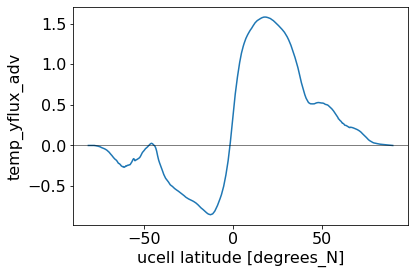

In [29]:
mht_CM2_025.plot()
plt.axhline(0, color='k', linewidth=0.5)

Calculate Atlantic transport at 26 N

In [54]:
%%time
mht_OM2_025_cycle4 = get_mht_lat_OM2_IAF('025deg_jra55_iaf_omip2_cycle4', session_OM2, lat_coord=26, start_time='1958-01-01', end_time='2018-12-31')
mht_OM2_025_cycle5 = get_mht_lat_OM2_IAF('025deg_jra55_iaf_omip2_cycle5', session_OM2, lat_coord=26, start_time='1958-01-01', end_time='2018-12-31')
mht_OM2_025_cycle6 = get_mht_lat_OM2_IAF('025deg_jra55_iaf_omip2_cycle6', session_OM2, lat_coord=26, start_time='1958-01-01', end_time='2018-12-31')

CPU times: user 24.2 s, sys: 933 ms, total: 25.1 s
Wall time: 42.2 s


In [57]:
%%time
mht_OM2_1_cycle4 = get_mht_lat_OM2_IAF('1deg_jra55_iaf_omip2_cycle4', session_OM2, lat_coord=26, start_time='1958-01-01', end_time='2018-12-31')
mht_OM2_1_cycle5 = get_mht_lat_OM2_IAF('1deg_jra55_iaf_omip2_cycle5', session_OM2, lat_coord=26, start_time='1958-01-01', end_time='2018-12-31')
mht_OM2_1_cycle6 = get_mht_lat_OM2_IAF('1deg_jra55_iaf_omip2_cycle6', session_OM2, lat_coord=26, start_time='1958-01-01', end_time='2018-12-31')

CPU times: user 9.97 s, sys: 535 ms, total: 10.5 s
Wall time: 24.6 s


In [28]:
mht = xr.concat([mht_CM2_025_26N_0_99, mht_CM2_025_26N_100_199, mht_CM2_025_26N_200_299, mht_CM2_025_26N_300_399, mht_CM2_025_26N_400_499], dim='year')
mht.to_netcdf(path_to_data + '/mht_CM2_025_26N_annual.nc')

In [35]:
mht = xr.concat([mht_CM2_1_0_99, mht_CM2_1_100_199, mht_CM2_1_200_299, mht_CM2_1_300_399, mht_CM2_1_400_499], dim='year')
mht.to_netcdf(path_to_data + '/Comparison_ACCESS_CM2_1/mht_CM2_1_26N_annual.nc')

Load data (previously calculated in this script, I deleted those cells)

In [67]:
mht_CM2_025 = xr.open_dataarray(path_to_data + 'mht_CM2_025_26N_annual.nc')
mht_CM2_1   = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/mht_CM2_1_26N_annual.nc')

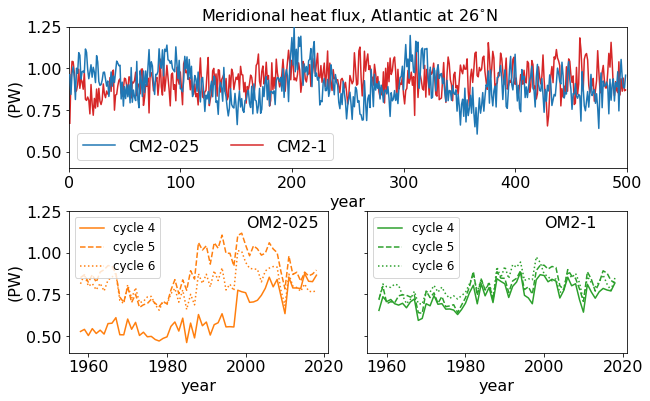

In [109]:
fig = plt.figure(figsize=(10,6))

gs  = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.3, wspace=0.15)

fig.add_subplot(gs[0,:])
mht_CM2_025.plot(label='CM2-025', color='C0', zorder=3)
mht_CM2_1.plot(label='CM2-1', color='C3')
plt.legend(ncol=2)
plt.ylim(0.4, 1.25)
plt.xlim(0, 500)
plt.ylabel('(PW)')
plt.title(' Meridional heat flux, Atlantic at 26$^{\circ}$N', fontsize=16)

fig.add_subplot(gs[1,0])
mht_OM2_025_cycle4.plot(color='C1', linestyle='-', label='cycle 4')
mht_OM2_025_cycle5.plot(color='C1', linestyle='--', label='cycle 5')
mht_OM2_025_cycle6.plot(color='C1', linestyle=':', label='cycle 6')
plt.legend(loc=2, fontsize=12)
plt.ylabel('(PW)')
plt.title('')
plt.text(2000, 1.15, 'OM2-025')
plt.ylim(0.4, 1.25)

fig.add_subplot(gs[1,1])
mht_OM2_1_cycle4.plot(color='C2', linestyle='-', label='cycle 4')
mht_OM2_1_cycle5.plot(color='C2', linestyle='--', label='cycle 5')
mht_OM2_1_cycle6.plot(color='C2', linestyle=':', label='cycle 6')
plt.legend(loc=2, fontsize=12)
plt.ylabel('')
plt.title('')
plt.text(2000, 1.15, 'OM2-1')
plt.ylim(0.4, 1.25)
plt.tick_params(labelleft=False)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_mht_26N_annual.png'
    plt.savefig(fig_path + fig_name);